# Problem
Three players A, B, C play the following game. First, A picks a real number between 0 and 1 (both inclusive), then B picks a number in the same range (different from A’s choice) and finally C picks a number, also in the same range, (different from the two chosen numbers). We then pick a number in the range uniformly randomly. Whoever’s number is closest to this random number wins the game. Assume that A, B and C all play optimally and their sole goal is to maximise their chances of winning. Also assume that if one of them has several optimal choices, then that player will randomly pick one of the optimal choices.

# Numerical solution
This problem is stated quite simple and at a first glance can be thought as naive. However, when it is tried to solve it is not that straightforward. Although simple in formulation, this game theory problem can provide some interesting insights. For instance, if we assume that the first player decides to pick the number in the center, then, the optimal solution for the other players is to pick a number as close as they can to the first player, each one on each side of the divided segment. This simplified behaviour can explain why sometimes competitive stores place near to each other in centric places.

In this notes we will try to solve this problem numerically. At first we tried to solve it by means of some type of _clever_ optimization method, however after some failed attempts, we changed the approach to solve it via dynamic programming. However, this has the implication of exploring the whole space of configurations, which is huge even for relatively coarse discretizations.

The problem can be extended to any arbitrary number of players.

In [ ]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

Next, there are presented the functions used to compute the solution of the problem.

In [2]:
# Computes the probabilities given the position choices.
def compute_probabilities (positions):
    
    probabilities = np.zeros(positions.shape)
    
    # Order the positions and apply the formula P_i = (x_{i+1} - x_{i-1})/2. For the first and
    # last positions, we have to consider that there is no left or right player respectively,
    # this is acchieved by considering the difference with respect -x_first and 2 - x_last respectively.
    position_order = np.argsort(positions)
    ord_positions = positions[position_order]
    swaped_probabilities = (np.diff(ord_positions, axis = 0, prepend = -ord_positions[0]) 
                            + np.diff(ord_positions, axis = 0, append = 2 - ord_positions[-1]))/2
    probabilities[position_order] = swaped_probabilities

    return probabilities

In [3]:
# Solves the problem for the current player given the discretization, the discrete segment, the number
# of players and the choices of the previous players. The solution is find recursively, assuming
# that the current player chooses certain values, then the problem is solved for the next player. 
# Finally it is taken the choice with larger probabiltiy for this player.
def solve_player (discretization, discrete_segment, player, number_of_players, selected_positions):
    
    # Set an index to zero 
    i = 0
    # Copy selected positions to not change its values.
    copy_selected_positions = np.copy(selected_positions)
    
    # Discard the positions already taken by other players to obtain the available positions.
    # Since the problem is clearly symmetric for the first player, we will only explore the
    # solutions from 0 to 0.5, this will save us some time.
    if (player == 0):
        available_positions = np.copy(discrete_segment[np.isin(discrete_segment, 
                                                               copy_selected_positions[:player], invert=True)])
        available_positions = available_positions[available_positions <= 0.5]
        
    else:
        available_positions = np.copy(discrete_segment[np.isin(discrete_segment, 
                                                               copy_selected_positions[:player], invert=True)])
        
    # There will be as much as available positions.
    n_available_positions = available_positions.shape[0]
    end_selections = np.zeros((n_available_positions, number_of_players))
    probabilities = np.zeros((n_available_positions, number_of_players))
        
    # If it is the last player just set the available positions as selections. We will only compute 
    # probabilities for the last player, and store its values for the next ones since we are 
    # doing a sorting to compute probabilities and might be expensive to repeat it for each player.
    if (player == number_of_players - 1):
        for selection in available_positions:
            copy_selected_positions[player] = selection
            end_selections[i, :] = copy_selected_positions
            probabilities[i, :] = np.transpose(compute_probabilities(end_selections[i, :]))
            i = i+1      
    # If it is not the last player, select a from the available positions and solve the problem 
    # for the next player to obtain the final choices of the other players given that selection 
    # and the corresponding probabilities.
    else:
        for selection in available_positions:
            copy_selected_positions[player] = selection
            [end_selections[i, :], probabilities[i, :]] = solve_player(discretization, discrete_segment, 
                                                                       player + 1, number_of_players, 
                                                                       copy_selected_positions)
            i = i+1

    # We will choose the best solution for this player in terms of its probability.    
    probability_order = np.argsort(probabilities[:, player])
    # As argmax give the first index with maximum value, if the index is not the last one then
    # we will have from that index to the last one of possible elections with the same probabilty
    # and we will choose one at random.
    max_index = np.argmax(probabilities[probability_order, player])
    # If max_index is the maximum index this random number will be that.
    r_index = random.randint(max_index, n_available_positions - 1)
    
    best_index_selection = probability_order[r_index]
    best_game = end_selections[best_index_selection, :]
    probabilities_best_game = probabilities[best_index_selection, :]

    return [best_game, probabilities_best_game]    

In [4]:
# Finds the solution to the problem by discretizing the space in discretization values and 
# exploring all possible values. When the number of players or the discretization increases,
# the complexity of the problem increases drastically. The solution is of order
# discretization^number_of_players.
def solution (discretization = 31, number_of_players = 4):
    # We create discretized set of values. 
    discrete_segment = np.append(np.arange(0, 1, 1/(discretization-1)), 1)
    
    # We set intial conditions to start solving the problem.
    initial_position = np.copy(discrete_segment[: number_of_players])
    
    # Solve the problem for the first player (player 0)
    result = solve_player(discretization, discrete_segment, player = 0, 
                          number_of_players = number_of_players, selected_positions = initial_position )
    
    return result

Now, we will compute the solution of the problem. As state in the comments of the functions, the algorithm to compute the solution is quite computationally expensive, since it explore all of the possible choices that player can make in the discretized space. For that reason the algorithm is of order $D^{n}$, where $D$ is the discretization and $n$ the number of players. Moreoever, the algorithm makes some array ordering in each step, that also increses in complexity when the number of players increase. For that reason, we will maintain a low discretization of the segment $[0, 1]$ and reduce it when increasing the players. That implies a low resolution of the solution, however, it is compute in a reasonable amount of time.

First, let's check the solution to the first question. We will apply the function *solve_player*, for the second player and setting the value of the first player to zero. Since we only have to solve the two left players, we can use a fair amount of discretization, in this case 101, leading to a theoretical precision of 0.01.

In [5]:
discretization = 101
discrete_segment = np.append(np.arange(0, 1, 1/(discretization-1)), 1)
# Remember that the first player is player 0 in the code.
player = 1
number_of_players = 3
selected_positions = [0.0, 0.0, 0.0]
# Call the function to solve the problem for player 2.
[positions, probabilities] = solve_player (discretization, discrete_segment, player, 
                                           number_of_players, selected_positions)
print("Positions: ", positions, "\nProbabilities: ", probabilities)

Positions:  [0.   0.67 0.07] 
Probabilities:  [0.035 0.63  0.335]


We can see, that in fact, the solution for the second player is $\frac{2}{3}$.

Now, let's check the second question. For this we will call the *solution* function with 3 players and a reduced discretization. For us, it is computed in a fair amount of time with 51 values.

In [6]:
[positions, probabilities] = solution(discretization = 51, number_of_players = 3)
print("Positions: ", positions, "\nProbabilities: ", probabilities)

Positions:  [0.24 0.78 0.28] 
Probabilities:  [0.26 0.47 0.27]


Again, the answer is what we expected for the first player $\frac{1}{4}$. Although... running this function several times, one can observe that not always give the proper solution. We will discuss it later.

Finally, we will compute the best choice for the first player in a game with 4 players. In this case we have obtained the solution in a fair amount of time using 16 points of discretization. Moreover, we will compute the optimal solution serveral times and as a result we will give the median since there is some noise that will be explained later. In fact, as we will see, having a lower resolution makes the solution less noisy.

In [7]:
iterations = 10
n_players = 4
positions = np.zeros((iterations, n_players))
probabilities = np.zeros((iterations, n_players))

for it in range(0, iterations):
    [positions[it,:], probabilities[it,:]] = solution(discretization = 16, number_of_players = n_players)
    
print("Positions: ", np.median(positions, axis = 0), "\nProbabilities: ", np.median(probabilities, axis = 0))

Positions:  [0.23333333 0.76666667 0.53333333 0.46666667] 
Probabilities:  [0.23333333 0.33333333 0.28333333 0.16666667]


In this case it seems to be pointing to a solution of the form $\frac{1}{5}$ for the first player.

Now, let's explore a little bit why we don't always get the same value for the best choice for the first player and why it is more problematic the higher the resolution and the number of players. For doing so, let's create the following functions in order to create some plots. We will plot, for each of the choices of the first player which are the best choices of the other players. 

In [8]:
def visual_representation (discretization, number_of_players):
    
    discrete_segment = np.append(np.arange(0, 1, 1/(discretization-1)), 1)

    # Initialize the initial position array
    initial_positions = np.copy(discrete_segment[: number_of_players])

    # Determine the values to do the representation
    a_values = discrete_segment
    
    # Initialize other values
    N = a_values.shape[0]
    positions = np.zeros((N, number_of_players))
    probabilities = np.zeros((N, number_of_players))

    # We solve the problem for each intitial value of the first player
    i=0
    for a in a_values:
        initial_positions[0] = a
        [positions[i,:], probabilities[i,:]] = solve_player(discretization, discrete_segment, 1, number_of_players, 
                                                       initial_positions)
        i = i+1

    # We will assume, in order to plot that value, that the best choice for the first player is 
    # 1/(number_of_players + 1), although this has not been proved and might be false, however, 
    # it is true for 3 players and seems to be true for 4 players too.
    x_values = [1/(number_of_players+1),1-1/(number_of_players+1)]
    
    # First we will plot the values up to a = 0.5, the symmetry point.
    a_half_index = positions[:, 0] <= 0.5
    for i in range(0, number_of_players):
        plt.plot(positions[a_half_index, 0], positions[a_half_index, i])
    plt.legend(["Player " + str(player) for player in (range(1, number_of_players + 2))])
    plt.axvline(x=x_values[0], color='grey', linestyle='--')
    plt.title("Final choices")
    plt.xlabel("First player choice")
    plt.ylabel("Player choice")
    plt.show()

    for i in range(0, number_of_players):
        plt.plot(positions[a_half_index, 0], probabilities[a_half_index, i])
    plt.legend(["Player " + str(player) for player in (range(1, number_of_players + 2))])
    plt.axvline(x=x_values[0], color='grey', linestyle='--')
    plt.title("Probabilities")
    plt.xlabel("First player choice")
    plt.ylabel("Probability")
    plt.show()
    
    # Now, in order to show the symmetry, we will plot the full values of a.
    for i in range(0, number_of_players):
        plt.plot(positions[:, 0], positions[:, i])
    plt.legend(["Player " + str(player) for player in (range(1, number_of_players + 2))])
    for x_val in x_values:
        plt.axvline(x=x_val, color='grey', linestyle='--')
    plt.title("Final choices, symmetry")
    plt.xlabel("First player choice")
    plt.ylabel("Player choice")
    plt.show()

    for i in range(0, number_of_players):
        plt.plot(positions[:, 0], probabilities[:, i])            
    plt.legend(["Player " + str(player) for player in (range(1, number_of_players + 2))])
    for x_val in x_values:
        plt.axvline(x=x_val, color='grey', linestyle='--')
    plt.title("Probabilities, symmetry")
    plt.xlabel("First player choice")
    plt.ylabel("Probability")
    plt.show()

Let's see what happens with the given computation of the question 2:

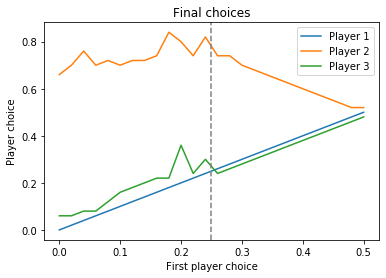

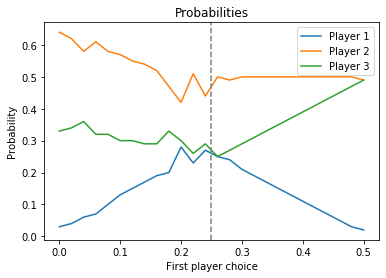

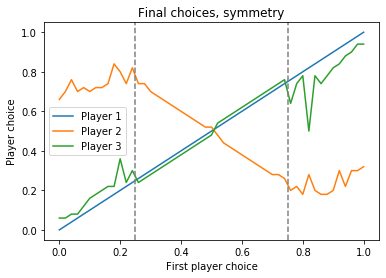

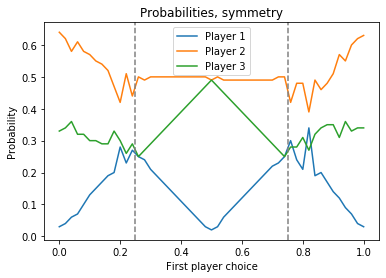

In [9]:
visual_representation (discretization = 51, number_of_players = 3)

First of all, in the first plot, we can notice that although the third player is supposed to be at any point in between the first and second player (choosed randomly) for values of the first player smaller than $\frac{1}{4}$, it is clearly biased towards the position of the first player. This can be explained by the fact that the solution is created from a particular realization of the third player picks, that is, that the selection of the second player is conditioned by the realization of the third player, choosing solutions that are not optimal but that in the particular realization of the random variable have been more benefitial. This also creates some bumps in the probability of the first player, that if are big enough can be higher that the real optima.  

A similar thing happens with 4 players, however, in this case it is more chaotic making the best choice oscillate over a wider range.

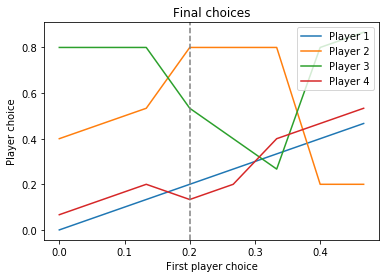

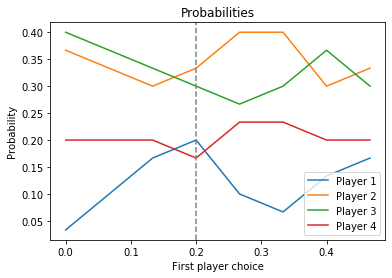

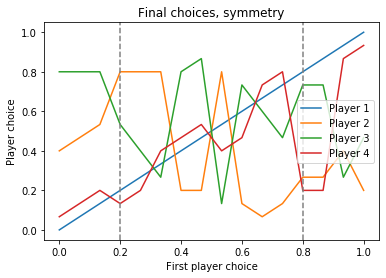

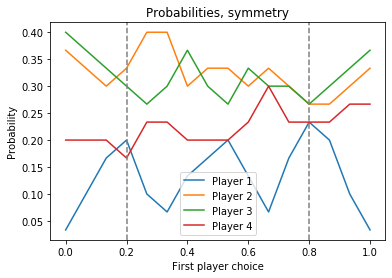

In [10]:
visual_representation (discretization = 16, number_of_players = 4)

We can observe that in this case there is an additional problem, and that is that the choice $\frac{1}{2}$ for the first player seems to be a local maximum. Then, due to this randomness in the choice of the solution and this local maximum we can obtain that the best value is at $\frac{1}{2}$.

For last, let's represent the same for 5 players and let's see that the things get more complicated and that is difficult to observe the best choice for the first player.

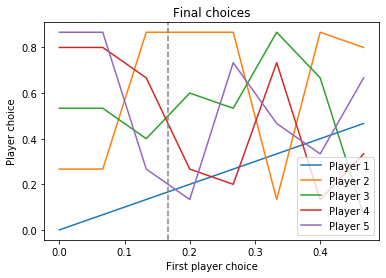

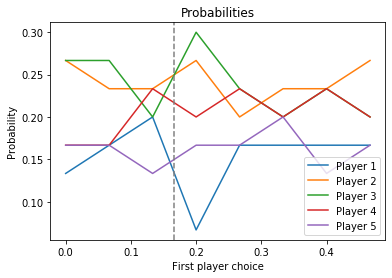

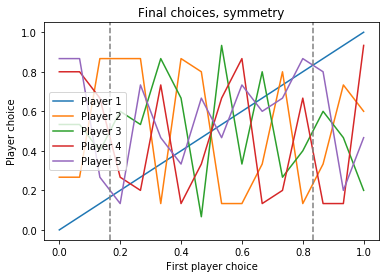

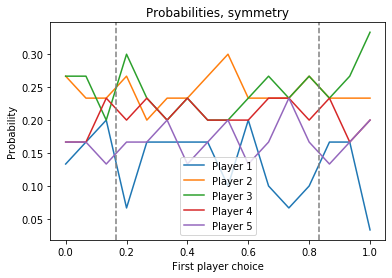

In [11]:
visual_representation (discretization = 16, number_of_players = 5)